### I. Dependencies

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import seaborn as sns

import numpy as np
np.random.seed(42)
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

print("All packages imported!")

All packages imported!


### II. Matplotlib Parameters

In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 9

In [3]:
# Latex document Text width
latex_width = 390.0

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## III. Color Palette

The palette is from the [iWantHue](http://medialab.github.io/iwanthue/) website by Mathieu Jacomy at the Sciences-Po Medialab.

In [4]:
colors = [
    "#ba4c40",
    "#45c097",
    "#573485",
    "#a8ae3e",
    "#8874d9",
    "#69a050",
    "#be64b2",
    "#bc7d36",
    "#5d8ad4",
    "#b94973"
]

## 1. Social Experiment Datasets

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 102

**Demographic:** Students in the department of computer science and engineering at IIT Kharagpur

**Length of Experiments:** 1 Hour

**Experiment:** Participants were presented with a topic through an online platform developed by the researchers. The platform allowed for the participants to post a message to 10 randomly assigned social neighbours (which were kept constant) and use a slider with range $[-1,1]$ ($[-10,10]$ in datasets) to represent their current stance on the topic. Each time a participant posted a message, the value of the slider and timestamp was recorded. Participants were not allowed to use the internet or communicate with others verbally.

3 datasets were collected, each with a different topic presented to the participants:
- Europe (-1) vs North America (1)
- IIT, Delhi (-1) vs IIT, Bombay (1)
- Startup (-1) vs Job (1)

Topics where chosen such that the majority of agents had no strong prior opinion, to allow for some change over time.

<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>friends.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique participant identifier $\,$ | 09CS3015 |
| `friend_ID`$\,$ | String$\,$ | Unique participant identifier for a social neighbour $\,$ | 13CS60R26 |

<center> <h4><code>messages.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique participant identifier$\,$ | 10CS30007 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Time at which participant posted an opinion$\,$ | 1379494480 |
| `opinion`$\,$ | Float $\in [-10,10]$ $\,$ | Self-reported stance towards the topic$\,$ | 1.1 |

### Questions about the data:

- What does the timestamp in the message files correspond to? Epoch time
- What was the start and end time of the experiments?
- Does every participant post a message? In the college and occupation datasets, 1 participant does not post anything. Will be considered neutral (0 in the vectors)
- Why do the friend files have 1020 rows? There are 102 participants.
- At what timestamp do we set the initial opinions? At the very first one, assume all others are 0.
- How will opinions be aggregated to timesteps? 

### 1.1 Importing

In [5]:
FRIEND_HEADERS = ['ID', 'friend_ID']
MESSAGE_HEADERS = ['ID', 'timestamp', 'opinion']

social_experiments_filepath = os.path.join(os.getcwd(), 'data', 'experiment')

continent_filepath = os.path.join(social_experiments_filepath, 'europe-vs-america')
continent_friends =  pd.read_csv(os.path.join(continent_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
continent_messages = pd.read_csv(os.path.join(continent_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

college_filepath = os.path.join(social_experiments_filepath, 'iitd-vs-iitb')
college_friends = pd.read_csv(os.path.join(college_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
college_messages = pd.read_csv(os.path.join(college_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

occupation_filepath = os.path.join(social_experiments_filepath, 'startup-vs-job')
occupation_friends = pd.read_csv(os.path.join(occupation_filepath, 'friends.txt'), sep= ' ', header = None, names = FRIEND_HEADERS)
occupation_messages = pd.read_csv(os.path.join(occupation_filepath, 'messages.txt'), sep= ' ', header = None, names = MESSAGE_HEADERS)

### 1.2 Cleaning

- All datatypes were correctly inferred
- There were no `NaN` values in the data.

#### Removing Duplicates from Message Datasets

All the `message.txt` datasets sets had duplicate rows which were removed. 

In [6]:
continent_duplicates = continent_messages[continent_messages.duplicated()]
continent_messages = continent_messages.drop_duplicates()

print(f'No. continent duplicates: {len(continent_duplicates)}')

No. continent duplicates: 38


In [7]:
college_duplicates = college_messages[college_messages.duplicated()]
college_messages = college_messages.drop_duplicates()

print(f'No. college duplicates: {len(college_duplicates)}')

No. college duplicates: 4


In [8]:
occupation_duplicates = occupation_messages[occupation_messages.duplicated()]
occupation_messages = occupation_messages.drop_duplicates()

print(f'No. occupation duplicates: {len(occupation_duplicates)}')

No. occupation duplicates: 21


### 1.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$, hence we must horizontally shift and compress the opinion values in the datasets. 

Trivially, we use $f(x) = \dfrac{x+10}{20}$.

In [9]:
continent_messages.opinion = (continent_messages.opinion + 10) / 20
college_messages.opinion = (college_messages.opinion + 10) / 20
occupation_messages.opinion = (occupation_messages.opinion + 10) / 20

### 1.4 Descriptive statistics

#### Europe vs North America (Continent)

In [10]:
continent_messages.describe()

,timestamp,opinion
count,2.144000e+03,2144.000000
mean,1.379496e+09,0.334841
std,8.469684e+02,0.276900
min,1.379494e+09,0.000000
25%,1.379495e+09,0.105000
50%,1.379496e+09,0.270000
75%,1.379497e+09,0.545000
max,1.379498e+09,1.000000


#### IIT, Delhi vs IIT, Bombay (College)

In [11]:
college_messages.describe()

,timestamp,opinion
count,1.754000e+03,1754.000000
mean,1.379501e+09,0.668213
std,5.720494e+02,0.268269
min,1.379500e+09,0.000000
25%,1.379500e+09,0.536250
50%,1.379500e+09,0.710000
75%,1.379501e+09,0.880000
max,1.379502e+09,1.000000


#### Startup vs Job (Occuptation)

In [12]:
occupation_messages.describe()

,timestamp,opinion
count,1.418000e+03,1418.000000
mean,1.379503e+09,0.444647
std,4.414919e+02,0.307805
min,1.379502e+09,0.000000
25%,1.379503e+09,0.161250
50%,1.379503e+09,0.402500
75%,1.379503e+09,0.703750
max,1.379504e+09,1.000000


### 1.5 Distribution of Opinions

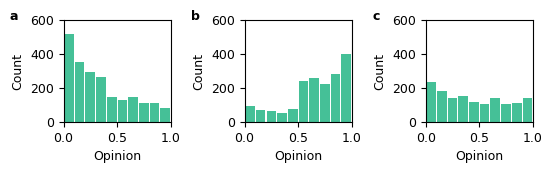

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3), height=350), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)


ax1.hist(continent_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,600)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Count')

ax2.hist(college_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,600)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Count')

ax3.hist(occupation_messages.opinion, bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,600)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Count')


ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
def outlier_cutoff(vals, q1, q3):
    """
    Essentially outlier cutoff, but clipped so that it does not go out of range
    """
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

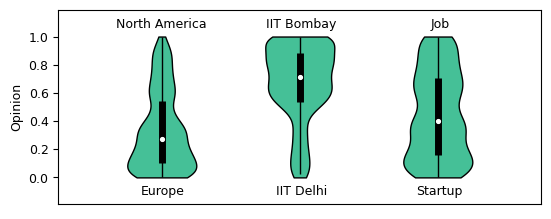

In [15]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=150), constrained_layout=True)


data = [sorted(continent_messages.opinion), sorted(college_messages.opinion), sorted(occupation_messages.opinion)]
labels = ['Continent', 'College', 'Occupation']


plot = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
ax.set_xlim(0.25, len(labels) + 0.75)
ax.set_ylim(-0.19,1.19)
#ax.set_xticks(np.arange(1, len(labels) + 1))
#ax.set_xticklabels(labels)
ax.set_xticks([])
ax.set_ylabel('Opinion')
for pc in plot['bodies']:
    pc.set_facecolor(colors[1])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

    
Q1s = [] 
medians = [] 
Q3s = []
for xs in data:
    Q1s.append(np.percentile(xs, 25))
    medians.append(np.percentile(xs, 50))
    Q3s.append(np.percentile(xs, 75))

    
whiskers = np.array([
    outlier_cutoff(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, Q1s, Q3s)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]


inds = np.arange(1, len(medians) + 1)
ax.scatter(inds, medians, marker='o', color='white', s=7.5, zorder=3)
ax.vlines(inds, Q1s, Q3s, color='black', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='black', linestyle='-', lw=1)

ax.text(0.17, 0.1, 'Europe', transform=ax.transAxes, va='top')
ax.text(0.12, 0.96, 'North America', transform=ax.transAxes, va='top')

ax.text(0.45, 0.1, 'IIT Delhi', transform=ax.transAxes, va='top')
ax.text(0.43, 0.96, 'IIT Bombay', transform=ax.transAxes, va='top')

ax.text(0.74, 0.1, 'Startup', transform=ax.transAxes, va='top')
ax.text(0.77, 0.96, 'Job', transform=ax.transAxes, va='top')

#plt.savefig('social_opinion_violinplot.pdf', format='pdf', bbox_inches='tight')
plt.show()

Distribution is a kernel density estimation of the probability density function of the opinion values.

### 1.6 Setting the Initial Opinion Component 

As we do not have access to the exact start and end times of the experiment, I see two potential ways of deciding the participants initial opinion:

1. Assume the experiment starts when the first opinion is posted. All individuals who have not posted are assumed to be neutral (0.5). The downside here is that the participant may not have had time to express their opinion, and all individuals except the first one posting will be 0.5, which seems quite unrealistic.
2. Use the last message posted by a participant or 0.5 if no post from the first timestep to set the initial opinions of each participant. This is has the downside that individuals may already be influenced by others in the first timestep. Although, this is not really an issue, any person is constantly being influenced prior to the experiment from their enviroment. This is also easier to generalize in the programming.

I choose to move forward with the second option as it will likely give a better picture of the initial opinion distribution and it suffers from much less downsides than the first option. However, one must keep in mind that if the timesteps are too small, the second option will act just like the first one.

In [16]:
def adj_mat(friend_data):
    ids = friend_data.ID.unique()
    adj = np.zeros(shape=(len(ids),len(ids)), dtype=np.float64)
    for row in friend_data.iterrows():
        ID = row[1]['ID']
        friend_ID = row[1]['friend_ID']
        adj[np.where(ids==row[1]['ID'])[0][0],np.where(ids==row[1]['friend_ID'])[0][0]] = 1
    for i in range(len(ids)):
        adj[i] = adj[i] / np.sum(adj[i])
    return ids, adj

In [17]:
def op_series(ids, msg_data, init_timestep, timestep):
    ts = []
    prtcn = []
    ops = []
    
    prev = msg_data.timestamp.min()
    cur = prev + init_timestep - 1 
    updates = msg_data[msg_data.timestamp.between(prev, cur)]
    opinions = np.full(len(ids),0.5)
    participation = np.zeros(len(ids))
    
    for i, ID in enumerate(ids):
        if ID in updates.ID.values:
            ID_updates = updates[updates.ID == ID]
            newest_idx = ID_updates.timestamp.idxmax()
            opinions[i] = ID_updates.loc[newest_idx].opinion
            participation[i] = 1
    ts.append(cur)
    prtcn.append(participation)
    ops.append(opinions)
    prev += init_timestep
    cur += init_timestep
        
    while prev <= msg_data.timestamp.max():
        updates = msg_data[msg_data.timestamp.between(prev, cur)]
        opinions = ops[-1].copy()
        participation = prtcn[-1].copy()
        for i, ID in enumerate(ids):
            if ID in updates.ID.values:
                ID_updates = updates[updates.ID == ID]
                newest_idx = ID_updates.timestamp.idxmax()
                opinions[i] = ID_updates.loc[newest_idx].opinion
                participation[i] = 1
           
        ts.append(cur)
        prtcn.append(participation)
        ops.append(opinions)
        prev += timestep
        cur += timestep
        
    return ts, list(map(lambda x: np.sum(x) / len(x), prtcn)), np.array(ops)

#### Cumulative Proportion of Participation

We will use a threshhold to determine the time use to collect the initial opinion. First we generate the opinion timeseries at the finest intervals, i.e., per second.

In [18]:
init_timestep = 1
reg_timestep = 1

continent_ids, continent_adj = adj_mat(continent_friends)
continent_ts, continent_prtcn, continent_ops = op_series(continent_ids, continent_messages, init_timestep, reg_timestep)

college_ids, college_adj =  adj_mat(college_friends)
college_ts, college_prtcn, college_ops = op_series(college_ids, college_messages, init_timestep, reg_timestep)

occupation_ids, occupation_adj =  adj_mat(occupation_friends)
occupation_ts, occupation_prtcn, occupation_ops = op_series(occupation_ids, occupation_messages, init_timestep, reg_timestep)

In [19]:
def geqidx(val, xs):
    return next((x[0] for x in enumerate(xs) if x[1] >= val), -1)

In [20]:
full_step = max(geqidx(1, college_prtcn), geqidx(1, occupation_prtcn),geqidx(1, continent_prtcn))

Full participation was reached for the continent experiment at 805 seconds. There is never full participation for the two other experiments, one person never participates for both. Same person with ID: **06CS3012**.

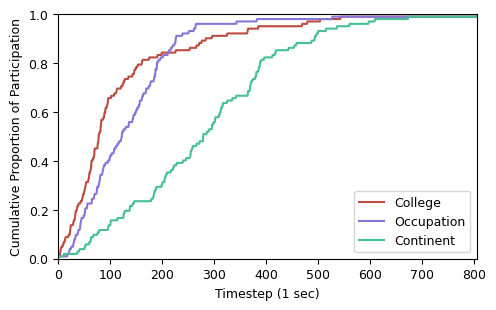

In [21]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height=latex_width * 0.6))

ax.plot(college_prtcn[:full_step], color=colors[0], label='College')
ax.plot(occupation_prtcn[:full_step], color=colors[4], label='Occupation')
ax.plot(continent_prtcn[:full_step], color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Cumulative Proportion of Participation')
ax.legend(loc='lower right')

#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

We use highest possible participation to create the initial opinion series.

In [22]:
continent_lim = geqidx(1, continent_prtcn)
continent_ts = continent_ts[continent_lim:]
continent_prctn = continent_prtcn[continent_lim:] 
continent_ops = continent_ops[continent_lim:]

college_lim = geqidx(101/102, college_prtcn)
college_ts = college_ts[college_lim:]
college_prctn = college_prtcn[college_lim:] 
college_ops = college_ops[college_lim:]

occupation_lim = geqidx(101/102, occupation_prtcn)
occupation_ts = occupation_ts[occupation_lim:]
occupation_prctn = occupation_prtcn[occupation_lim:] 
occupation_ops = occupation_ops[occupation_lim:]

#### By time (full prop time)

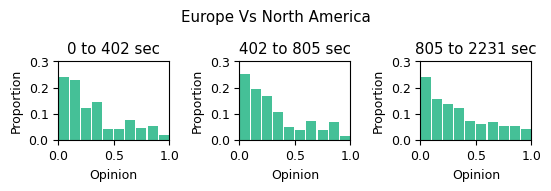

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = continent_messages.timestamp.min()
time1 = time0 + int(continent_lim / 2)
time2 = time0 + continent_lim
end = continent_messages.timestamp.max()

data1 = continent_messages[continent_messages.timestamp.between(time0, time1)].opinion
data2 = continent_messages[continent_messages.timestamp.between(time1, time2)].opinion
data3 = continent_messages[continent_messages.timestamp.between(time1, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(continent_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(continent_lim / 2)} to {continent_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{continent_lim} to {len(continent_ops)} sec')

fig.suptitle('Europe Vs North America')

#ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
#ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
#ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

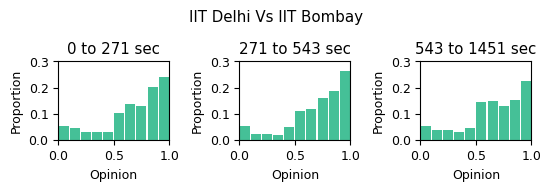

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = college_messages.timestamp.min()
time1 = time0 + int(college_lim / 2)
time2 = time0 + college_lim
end = college_messages.timestamp.max()

data1 = college_messages[college_messages.timestamp.between(time0, time1)].opinion
data2 = college_messages[college_messages.timestamp.between(time1, time2)].opinion
data3 = college_messages[college_messages.timestamp.between(time1, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(college_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(college_lim / 2)} to {college_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{college_lim} to {len(college_ops)} sec')

fig.suptitle('IIT Delhi Vs IIT Bombay')

#ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
#ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
#ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

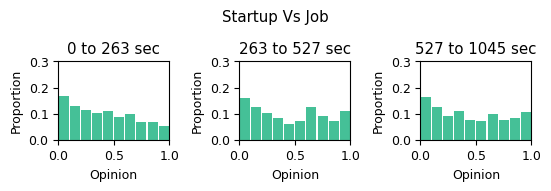

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = occupation_messages.timestamp.min()
time1 = time0 + int(occupation_lim / 2)
time2 = time0 + occupation_lim
end = occupation_messages.timestamp.max()

data1 = occupation_messages[occupation_messages.timestamp.between(time0, time1)].opinion
data2 = occupation_messages[occupation_messages.timestamp.between(time1, time2)].opinion
data3 = occupation_messages[occupation_messages.timestamp.between(time1, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to {int(occupation_lim / 2)} sec')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title(f'{int(occupation_lim / 2)} to {occupation_lim} sec')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title(f'{occupation_lim} to {len(occupation_ops)} sec')

fig.suptitle('Startup Vs Job')

#ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
#ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
#ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

At what proportion of participation do we have equilibrium?

How do we conclude that equilibrium has been reached?

#### By proportion

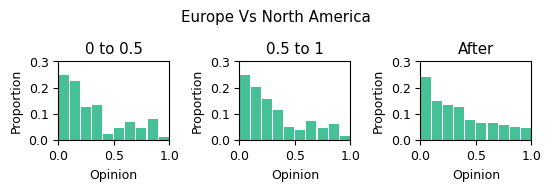

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = continent_messages.timestamp.min()
time1 = time0 + geqidx(0.5, continent_prtcn)
time2 = time0 + geqidx(1, continent_prtcn)
end = continent_messages.timestamp.max()

data1 = continent_messages[continent_messages.timestamp.between(time0, time1)].opinion
data2 = continent_messages[continent_messages.timestamp.between(time1, time2)].opinion
data3 = continent_messages[continent_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('Europe Vs North America')

#ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
#ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
#ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

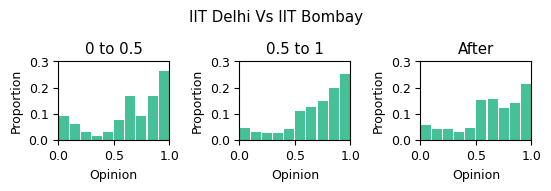

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = college_messages.timestamp.min()
time1 = time0 + geqidx(0.5, college_prtcn)
time2 = time0 + geqidx(101/102, college_prtcn)
end = college_messages.timestamp.max()

data1 = college_messages[college_messages.timestamp.between(time0, time1)].opinion
data2 = college_messages[college_messages.timestamp.between(time1, time2)].opinion
data3 = college_messages[college_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title(f'0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('IIT Delhi Vs IIT Bombay')

#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

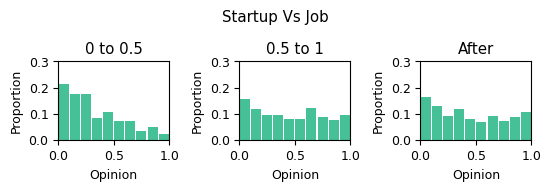

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=set_size(subplots=(1, 3)), constrained_layout=True)

bins = np.arange(0,1.05,0.1)
ticks = np.arange(0,1.5,0.5)

time0 = occupation_messages.timestamp.min()
time1 = time0 + geqidx(0.5, occupation_prtcn)
time2 = time0 + geqidx(101/102, occupation_prtcn)
end = occupation_messages.timestamp.max()

data1 = occupation_messages[occupation_messages.timestamp.between(time0, time1)].opinion
data2 = occupation_messages[occupation_messages.timestamp.between(time1, time2)].opinion
data3 = occupation_messages[occupation_messages.timestamp.between(time2, end)].opinion

ax1.hist(data1, weights=np.ones(len(data1)) / len(data1), bins=bins, rwidth=0.9, color=colors[1])
ax1.set_xlim(0,1)
ax1.set_xticks(ticks)
ax1.margins(x=0)
ax1.set_ylim(0,0.3)
ax1.set_xlabel('Opinion')
ax1.set_ylabel('Proportion')
ax1.set_title('0 to 0.5')

ax2.hist(data2, weights=np.ones(len(data2)) / len(data2), bins=bins, rwidth=0.9, color=colors[1])
ax2.set_xlim(0,1)
ax2.set_ylim(0,0.3)
ax2.set_xticks(ticks)
ax2.margins(x=0)
ax2.set_xlabel('Opinion')
ax2.set_ylabel('Proportion')
ax2.set_title('0.5 to 1')

ax3.hist(data3, weights=np.ones(len(data3)) / len(data3), bins=bins, rwidth=0.9, color=colors[1])
ax3.set_xlim(0,1)
ax3.set_ylim(0,0.3)
ax3.set_xticks(ticks)
ax3.margins(x=0)
ax3.set_xlabel('Opinion')
ax3.set_ylabel('Proportion')
ax3.set_title('After')

fig.suptitle('Startup Vs Job')

#ax1.text(-0.5, 1.1, 'a', transform=ax1.transAxes, fontweight='bold', va='top')
#ax2.text(-0.5, 1.1, 'b', transform=ax2.transAxes, fontweight='bold', va='top')
#ax3.text(-0.5, 1.1, 'c', transform=ax3.transAxes, fontweight='bold', va='top')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

Consensus is already reached when half the participants have expressed their opinion.


Cumulative percentage who have talked
-> Can be used to decide initial collecting time
- Determine if converge is really happening or just how we set opinions? take snapshot from seconds before limit is reached and after, is there a significant different in distribution of opinions? we can conclude its fine to start from total distribution, but we should find out when equilibrium has not been reached yet, quite early. By 0.5 participation, bit of a problem, cuz we want full participation.


### 1.7 Visualising Opinion Time Series

I tried computing the waterfall plot, however, as peoples opinions change so much, it does not look very continous. I also tried visualising the networks, however, they were too dense to find anything interesting. I did have success by recording the mean opinion value at each time step. There seems to be a convergence within the first ~8.3 minutes (500 seconds), where for all the experiments, the mean opinion value have lost there monotonous behaviour. 

Theta can be calculated from mean opinion plot, but can it be done mathematically?

The normal distribution of the opinions means after stability point is false.

In [29]:
def means(xs):
    means = []
    for x in xs:
        means.append(np.mean(x))
    return means

continent_ops_means = means(continent_ops)
college_ops_means = means(college_ops)
occupation_ops_means = means(occupation_ops)

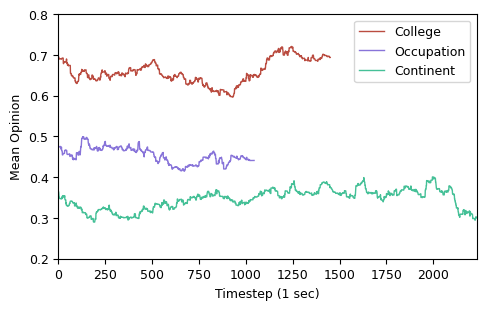

In [30]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

ax.plot(college_ops_means, linewidth=1, color=colors[0], label='College')
ax.plot(occupation_ops_means, linewidth=1.0,color=colors[4], label='Occupation')
ax.plot(continent_ops_means, linewidth=1.0,color=colors[1], label='Continent')
ax.margins(x=0)
ax.set_ylim(0.2,0.8)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Mean Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

Here, we see further that consensus is reached when full participation in initial opinion component.

In [31]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### 1.8 Comparing a participant with their neighbours

In [32]:
def get_friends(ID, friends):
    return friends[friends.ID == ID].friend_ID

In [33]:
def get_idx(ids, ID):
    return np.where(ids == ID)[0][0]

In [55]:
def friend_analysis(ids, friends, ops):
    dist_result = []
    corr_result = []

    for idx, ID in enumerate(ids):
        friend_data = [ ops[:, get_idx(ids, friend)] for friend in get_friends(ID, friends)]
        mean_friend_data = means(np.transpose(friend_data))
        id_data = ops[:, idx]
        dist = np.abs(np.mean(id_data))
        friend_corr = np.corrcoef(id_data, mean_friend_data)[0, 1]

        dist_result.append(dist)
        corr_result.append(friend_corr)
    
    return dist_result, corr_result

<AxesSubplot:>

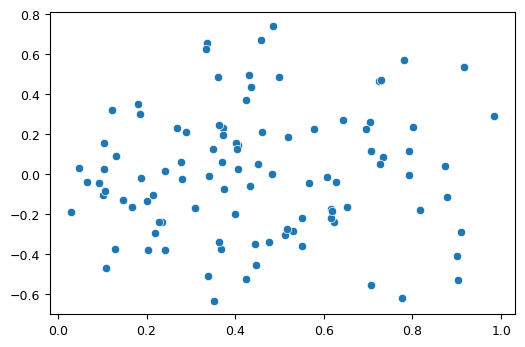

In [95]:
a, b = friend_analysis(occupation_ids, occupation_friends, occupation_ops)

sns.scatterplot(a, b)

In [84]:
del a[41]
del b[41]

In [96]:
b

[0.30056843130355887,
 0.11452161188441443,
 0.1541290503346119,
 0.6543389191667935,
 0.18436599550295837,
 0.02821137630572956,
 0.08558428761898129,
 -0.01972946779428949,
 -0.06060156475280199,
 0.6719798820038129,
 -0.2382634787964155,
 -0.036842175991822934,
 -0.0037240263070785914,
 0.029532994603694684,
 0.26048252375757375,
 -0.11198114985353534,
 0.14590980528679953,
 -0.5527982469521211,
 -0.5271022607047607,
 0.6242997703324025,
 -0.3014287333243916,
 -0.23935786966435443,
 0.00041879797412522075,
 -0.6317947723175841,
 0.1563392646939574,
 0.11759581819834548,
 0.23169786430275421,
 -0.4563675136001973,
 0.06113957770555515,
 0.2093299817185241,
 -0.35653896874592766,
 -0.3500466173988091,
 -0.6202098055815236,
 0.2280865449998954,
 0.4689437686500002,
 -0.2862163091137903,
 nan,
 0.536607473086201,
 -0.4665410942832112,
 -0.07308023026593011,
 0.12525439726603718,
 nan,
 0.2727155107059291,
 -0.3796841944349362,
 0.2905568606407676,
 -0.18987992306927584,
 -0.273974532266

In [86]:
np.corrcoef(a,b)[0,1]

nan

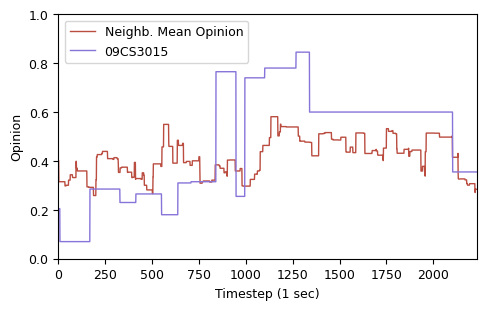

In [48]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = latex_width * 0.6))

labels = get_friends('09CS3015', continent_friends)
data = [ continent_ops[:, get_idx(continent_ids, friend)] for friend in labels]
mean_data = means(np.transpose(data))


ax.plot(mean_data, linewidth=1.0, color=colors[0], label='Neighb. Mean Opinion')
ax.plot(continent_ops[:, get_idx(continent_ids,'09CS3015')], linewidth=1.0,color=colors[4], label='09CS3015')
ax.margins(x=0)
ax.set_ylim(0,1)
ax.set_xlabel(f'Timestep ({reg_timestep} sec)')
ax.set_ylabel('Opinion')
ax.legend()


#plt.savefig('social_opinion_all_means.pdf', format='pdf', bbox_inches='tight')
plt.show()

### 2.1 Importing

In [ ]:
NODE_HEADERS = ['ID']
EDGE_HEADERS = ['ID', 'friend_ID']
OPINION_HEADERS = ['ID', 'timestamp', 'opinion']

social_media_filepath = os.path.join(os.getcwd(), 'data', 'media')

twitter_filepath = os.path.join(social_media_filepath, 'twitter')
twitter_nodes =  pd.read_csv(os.path.join(twitter_filepath, 'nodelist.txt'), sep= ' ', header = None, names = NODE_HEADERS)
twitter_edges = pd.read_csv(os.path.join(twitter_filepath, 'edgelist.txt'), sep= ' ', header = None, names = EDGE_HEADERS)
twitter_opinions = pd.read_csv(os.path.join(twitter_filepath, 'opinion.txt'), sep= ' ', header = None, names = OPINION_HEADERS)

### 2.2 Cleaning

- There were no duplicates
- No NaN values or outliers

#### Correcting Inferred Variable Types

All ID fields have been incorrectly inferred to `int64` when they should be `object` types.

In [ ]:
twitter_nodes.ID = twitter_nodes.ID.astype(str)
twitter_edges.ID = twitter_edges.ID.astype(str)
twitter_edges.friend_ID = twitter_edges.friend_ID.astype(str)
twitter_opinions.ID = twitter_opinions.ID.astype(str)

### 2.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$ 

Trivially, we use $f(x) = \dfrac{x-x_{min}}{x_{max} - x_{min}}$.

Where $x_{min} = -6.48366001409$ and $x_{max} = 4.52493159834$.

In [ ]:
twitter_opinions.opinion = (twitter_opinions.opinion - twitter_opinions.opinion.min()) / (twitter_opinions.opinion.max() - twitter_opinions.opinion.min())

### 2.4 Descriptive statistics

In [ ]:
twitter_opinions.describe()

### 2.5 Distribution of Opinions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = 180))

bins = np.arange(0,1.05,0.05)
ticks = np.arange(0,1.05,0.1)


ax.hist(twitter_opinions.opinion, bins, rwidth=0.9, color=colors[1])
ax.set_xlim(0,1)
ax.set_xticks(ticks)
ax.margins(x=0)
ax.set_ylim(0,7000)
ax.set_xlabel('Opinion')
ax.set_ylabel('Count')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 3. Reddit Dataset

**Provenance:** Abir De, Sourangshu Bhattacharya, Parantapa Bhattacharya, Niloy Ganguly, and Soumen Chakrabarti. “Learning a Linear Influence Model from Transient Opinion Dynamics.” *Proceedings of the 23rd ACM International Conference on Information and Knowledge Management*, 2014. 

Abir De gave the datasets upon request via email.  

**Sample size:** 556*

**Demographic:** Anybody who posted in the 'politics' subreddit between July 1 and December 31, 2012.

Look deeper into the characterisation of political orientation of Reddit Politics users, and potential ramifications for our results.

**Dates on which tweets where collected:** July 1 to December 31, 2012.

**Explanation:** All users who posted on the 'politics' subreddit between July 1 and December 31, 2012 were recorded. This resulted in ~31,000 users, from which a undirected user network was created, in which an edge means that the two users posted in two of the same subreddits in the given time period (excluding politics). The ~500 users were randomly selected such that they formed a single connected component where each user had over 20 submissions in the given time period. In contrast to the Twitter data, given that there is no character restrictions, most posts are made with well-formed english. This led to the use of the LIWC to calculate the opinion score. The opinion score of each post was equal to the normalised difference between the positive emotion score and the negative emotion score, where normalisation was mapping the range of values to $[-1,1]$ using linear scaling.

**Sentiment Analysis Tool:** J. W. Pennebaker, M. E. Francis, and R. J. Booth. LIWC:
Linguistic Inquiry and Word Count. liwc.net, 2007.
Accessed on June 03, 2014.

`* Filtering down from ~31,000 users.`


#### Critique

- Are people really friends / contacts if they post in the two same subreddits over a 6 month period?
- Most posts go unnoticed, how do we know that the users saw each others posts?
- Similar problems with sentiment analysis as for Twitter data

<center> <h3>Dataset Contents</h3> </center>

<center> <h4><code>nodelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 19457 |

<center> <h4><code>edgelist.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `ID`$\,$ | String$\,$ | Unique user identifier $\,$ | 13 |
| `friend_ID`$\,$ | String$\,$ | Unique user identifier for a followee $\,$ | 5083 |


<center> <h4><code>edgex.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `???`$\,$ | $\,$ | $\,$ | 11 |
| `???`$\,$ | $\,$ | $\,$ | 1 |


<center> <h4><code>opinion.txt</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `id`$\,$ | String$\,$ | Unique user identifier$\,$ | 13 |
| `???`$\,$ | $\,$ | $\,$ | 58092647 |
| `timestamp`$\,$ | Unix Timestamp$\,$ | Time at which user posted$\,$ | 1345566466 |
| `opinion`$\,$ | Float $\in [?,?]$ $\,$ | Sentiment analysis of post $\,$ | -15.38 |

### Questions about the data:

- Is the `friend_ID` a follower or followee? Followee by principle of the social experiment datasets
- What is  the range of values for opinions?

### 3.1 Importing

In [ ]:
EDGEX_HEADERS = ['na1', 'na2']
OPINION_HEADERS = ['ID', 'na', 'timestamp', 'opinion']

social_media_filepath = os.path.join(os.getcwd(), 'data', 'media')

reddit_filepath = os.path.join(social_media_filepath, 'reddit')
reddit_nodes =  pd.read_csv(os.path.join(reddit_filepath, 'nodelist.txt'), sep= ' ', header = None, names = NODE_HEADERS)
reddit_edges = pd.read_csv(os.path.join(reddit_filepath, 'edgelist.txt'), sep= ' ', header = None, names = EDGE_HEADERS)
reddit_edgex = pd.read_csv(os.path.join(reddit_filepath, 'edgex.txt'), sep= ' ', header = None, names = EDGEX_HEADERS)
reddit_opinions = pd.read_csv(os.path.join(reddit_filepath, 'opinion.txt'), sep= ' ', header = None, names = OPINION_HEADERS)

### 3.2 Cleaning

- There were no duplicates
- No NaN values or outliers

#### Correcting Inferred Variable Types

All ID fields have been incorrectly inferred to `int64` when they should be `object` types.

In [ ]:
reddit_nodes.ID = reddit_nodes.ID.astype(str)
reddit_edges.ID = reddit_edges.ID.astype(str)
reddit_edges.friend_ID = reddit_edges.friend_ID.astype(str)
reddit_opinions.ID = reddit_opinions.ID.astype(str)

### 3.3 Scaling of Opinion Values

The Higham and Mantzaris network model has opinions ranged $[0,1]$ 

Trivially, we use $f(x) = \dfrac{x-x_{min}}{x_{max} - x_{min}}$.

Where $x_{min} = -100$ and $x_{max} = 100$.

In [ ]:
reddit_opinions.opinion = (reddit_opinions.opinion + 100) / 200

### 3.4 Descriptive statistics

In [ ]:
reddit_opinions.describe()

### 3.5 Distribution of Opinions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=set_size(subplots=(1, 1), height = 180))

bins = np.arange(0,1.05,0.05)
ticks = np.arange(0,1.05,0.1)


ax.hist(reddit_opinions.opinion,bins, rwidth=0.9, color=colors[1])
ax.set_xlim(0,1)
ax.set_xticks(ticks)
ax.margins(x=0)
ax.set_ylim(0, 50000)
ax.set_xlabel('Opinion')
ax.set_ylabel('Count')


#plt.savefig('social_opinion_histograms.pdf', format='pdf', bbox_inches='tight')
plt.show()